In [1]:
import torch
import numpy as np

print(torch.__version__)
print(torch.cuda.is_available())

1.2.0
True


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# tensor 和numpy 的关系

# 创建np array 和 创建 tensor 
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(x_numpy, x_torch)
print()

# Tensor 和 numpy 的转换
print('to and from numpy and pytorch')
print(torch.from_numpy(x_numpy), x_torch.numpy())
print()

# numpy 和 Tensor都可以做 +-*%
y_numpy = np.array([3,4,5.])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(x_numpy + y_numpy, x_torch + y_torch)
print()

# np 中的方法， pytorch中很多都有. 例如norm ,二阶范数
# 但有部分高级的矩阵计算Tensor并不支持，比如计算特征值特征向量等。
# 因此numpy还是有存在的必要的。
print("norm")
print(np.linalg.norm(x_numpy), torch.norm(x_torch))
print()

# to apply an operation along a dimension,
# we use the dim keyword argument instead of axis
print("mean along the 0th dimension")
x_numpy = np.array([[1,2],[3,4.]])
x_torch = torch.tensor([[1,2],[3,4.]])
print(np.mean(x_numpy, axis=0), torch.mean(x_torch, dim=0))

x_numpy, x_torch
[0.1 0.2 0.3] tensor([0.1000, 0.2000, 0.3000])

to and from numpy and pytorch
tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64) [0.1 0.2 0.3]

x+y
[3.1 4.2 5.3] tensor([3.1000, 4.2000, 5.3000])

norm
0.37416573867739417 tensor(0.3742)

mean along the 0th dimension
[2. 3.] tensor([2., 3.])


- 转换维度 torch用Tensor.view(), numpy用reshape
- 压缩维度和新增维度 Tensor.squeeze( ) / Tensor.unsqueeze( )

In [4]:
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

print(X.shape)
print(X.view(N, C, 784).shape)
print(X.view(-1, C, 392).shape) # automatically choose the 0th dimension

print(X.size())
X = X.unsqueeze(0)
print(X.size())
X = X.squeeze(0)
print(X.size())

torch.Size([10000, 3, 28, 28])
torch.Size([10000, 3, 784])
torch.Size([20000, 3, 392])
torch.Size([10000, 3, 28, 28])
torch.Size([1, 10000, 3, 28, 28])
torch.Size([10000, 3, 28, 28])


## Variable( 过去式）

tensor是Pytorch中非常高效数据格式，但用曾经的 tensor构建神经网络还远远不够，为了构建计算图，所以Variable是不可或缺的数据形式。Variable是对tensor的封装。
Variable有三个属性：

1. .data：tensor本身
2. .grad：对应tensor的梯度
3. .grad_fn：该Variable是通过什么方式获得的

In [5]:
c = Variable(torch.tensor(2.0),requires_grad =True)

a = torch.tensor(2.0, requires_grad=True) # we set requires_grad=True to let PyTorch know to keep the graph
b = torch.tensor(1.0, requires_grad=True)
c = a + b
d = b + 1
e = c * d
print('c', c)
print('d', d)
print('e', e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


## cpu和gpu切换

In [6]:
cpu = torch.device("cpu")
gpu = torch.device("cuda") # ...我的电脑没装cuda

x = torch.rand(10)
print(x)
x = x.to(gpu)
print(x)
x = x.to(cpu)
print(x)

tensor([0.7492, 0.3611, 0.6825, 0.5192, 0.1796, 0.4305, 0.1121, 0.0865, 0.0929,
        0.9328])
tensor([0.7492, 0.3611, 0.6825, 0.5192, 0.1796, 0.4305, 0.1121, 0.0865, 0.0929,
        0.9328], device='cuda:0')
tensor([0.7492, 0.3611, 0.6825, 0.5192, 0.1796, 0.4305, 0.1121, 0.0865, 0.0929,
        0.9328])


Now that we have seen that PyTorch keeps the graph around for us, let's use it to compute some gradients for us.

Consider the function 𝑓(𝑥)=(𝑥−2)^2 .

Q: Compute 𝑓'(𝑥) and then compute 𝑓′(1) .

We make a backward() call on the leaf variable (y) in the computation, computing all the gradients of y at once.

## Gradient

In [7]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('PyTorch\'s f\'(x):', x.grad)

Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's f'(x): tensor([-2.])


## Using Gradient

In [13]:
x = torch.tensor([5.0], requires_grad=True)
step_size = 0.25

print('iter,\tx,\tf(x),\tf\'(x),\tf\'(x) pytorch')
for i in range(15):
    y = f(x)
    y.backward() #计算梯度
    
    print('{},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    x.data = x.data - step_size * x.grad # perform a GD update step
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    x.grad.detach_()
    x.grad.zero_()

iter,	x,	f(x),	f'(x),	f'(x) pytorch
0,	5.000,	9.000,	6.000,	6.000
1,	3.500,	2.250,	3.000,	3.000
2,	2.750,	0.562,	1.500,	1.500
3,	2.375,	0.141,	0.750,	0.750
4,	2.188,	0.035,	0.375,	0.375
5,	2.094,	0.009,	0.188,	0.188
6,	2.047,	0.002,	0.094,	0.094
7,	2.023,	0.001,	0.047,	0.047
8,	2.012,	0.000,	0.023,	0.023
9,	2.006,	0.000,	0.012,	0.012
10,	2.003,	0.000,	0.006,	0.006
11,	2.001,	0.000,	0.003,	0.003
12,	2.001,	0.000,	0.001,	0.001
13,	2.000,	0.000,	0.001,	0.001
14,	2.000,	0.000,	0.000,	0.000


## torch.nn.Module

Module is PyTorch's way of performing operations on tensors. Modules are implemented as subclasses of the torch.nn.Module class. All modules are callable and can be composed together to create complex functions.

### nn.Linear( )

In [16]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)
example_tensor = torch.tensor([[1., 2., 3.], [4. ,5. ,6.]])

transformed = linear_module(example_tensor)

print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transormed torch.Size([2, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[-0.3501, -0.4159,  0.5708],
        [ 0.4350,  0.4894,  0.3997],
        [ 0.2655, -0.2392,  0.0812],
        [-0.0085,  0.3861, -0.5370]], requires_grad=True)
b: Parameter containing:
tensor([ 0.5384, -0.1964, -0.2239, -0.3394], requires_grad=True)


### Activation Function
Relu, Tanh, Sigmoid   
need to be instantiated.

In [17]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


In [18]:
activation_fn = nn.Tanh() # we instantiate an instance of the Tanh module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([-0.7616,  0.7616,  0.0000])


In [25]:
activation_fn = nn.Sigmoid() # we instantiate an instance of the sigmoid module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0.2689, 0.7311, 0.5000])


## Convolutions

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')


When working with images, we often want to use convolutions to extract features using convolutions. PyTorch implments this for us in the torch.nn.Conv2d module. It expects the input to have a specific dimension  (𝑁,𝐶𝑖𝑛,𝐻𝑖𝑛,𝑊𝑖𝑛)  where  𝑁  is batch size,  𝐶𝑖𝑛  is the number of channels the image has, and  𝐻𝑖𝑛,𝑊𝑖𝑛  are the image height and width respectively.

We can modify the convolution to have different properties with the parameters:

kernel_size
stride
padding
They can change the output dimension so be careful.

In [26]:
# an entire mnist digit
image = np.array([0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3803922 , 0.37647063, 0.3019608 ,0.46274513, 0.2392157 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3529412 , 0.5411765 , 0.9215687 ,0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 ,0.9843138 , 0.9843138 , 0.9725491 , 0.9960785 , 0.9607844 ,0.9215687 , 0.74509805, 0.08235294, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.54901963,0.9843138 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.7411765 , 0.09019608, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8862746 , 0.9960785 , 0.81568635,0.7803922 , 0.7803922 , 0.7803922 , 0.7803922 , 0.54509807,0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 ,0.5019608 , 0.8705883 , 0.9960785 , 0.9960785 , 0.7411765 ,0.08235294, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.14901961, 0.32156864, 0.0509804 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.13333334,0.8352942 , 0.9960785 , 0.9960785 , 0.45098042, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.32941177, 0.9960785 ,0.9960785 , 0.9176471 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.32941177, 0.9960785 , 0.9960785 , 0.9176471 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.4156863 , 0.6156863 ,0.9960785 , 0.9960785 , 0.95294124, 0.20000002, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.09803922, 0.45882356, 0.8941177 , 0.8941177 ,0.8941177 , 0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.94117653, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.26666668, 0.4666667 , 0.86274517,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.5568628 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.14509805, 0.73333335,0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 , 0.8745099 ,0.8078432 , 0.8078432 , 0.29411766, 0.26666668, 0.8431373 ,0.9960785 , 0.9960785 , 0.45882356, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.4431373 , 0.8588236 , 0.9960785 , 0.9490197 , 0.89019614,0.45098042, 0.34901962, 0.12156864, 0., 0.,0., 0., 0.7843138 , 0.9960785 , 0.9450981 ,0.16078432, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.6627451 , 0.9960785 ,0.6901961 , 0.24313727, 0., 0., 0.,0., 0., 0., 0., 0.18823531,0.9058824 , 0.9960785 , 0.9176471 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.07058824, 0.48627454, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.32941177, 0.9960785 , 0.9960785 ,0.6509804 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.54509807, 0.9960785 , 0.9333334 , 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8235295 , 0.9803922 , 0.9960785 ,0.65882355, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.9490197 , 0.9960785 , 0.93725497, 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.34901962, 0.9843138 , 0.9450981 ,0.3372549 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.01960784,0.8078432 , 0.96470594, 0.6156863 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.01568628, 0.45882356, 0.27058825,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.], dtype=np.float32)
image_torch = torch.from_numpy(image).view(1, 1, 28, 28)

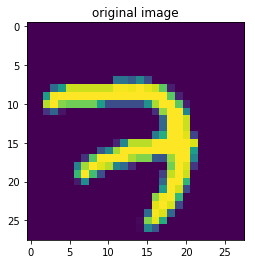

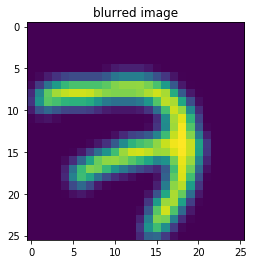

In [29]:
# a gaussian blur kernel
gaussian_kernel = torch.tensor([[1., 2, 1],[2, 4, 2],[1, 2, 1]]) / 16.0

conv = nn.Conv2d(1, 1, 3)
# manually set the conv weight
conv.weight.data[:] = gaussian_kernel

convolved = conv(image_torch)

plt.title('original image')
plt.imshow(image_torch.view(28,28).detach().numpy())
plt.show()

#当我们训练网络的时候可能希望保持一部分的网络参数不变，
# 只对其中一部分的参数进行调整；
#或者值训练部分分支网络，并不让其梯度对主网络的梯度造成影响
#这时候我们就需要使用detach()函数来切断一些分支的反向传播

plt.title('blurred image')
plt.imshow(convolved.view(26,26).detach().numpy()) 
plt.show()

## Sequential

What if we want to compose modules together ?
torch.nn.Sequential offer a excellent interface of composing modules elements.

In [30]:
d_in = 3
d_hidden = 4
d_out = 1

model = torch.nn.Sequential(
    nn.Linear(d_in ,d_hidden),
    nn.Tanh(),
    nn.Linear(d_hidden, d_out),
    nn.Sigmoid()
)

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor)
print('transformed', transformed.shape)

transformed torch.Size([2, 1])


## Parameters

In [32]:
params = model.parameters()

for param in params:
    print(param)

Parameter containing:
tensor([[ 0.2804, -0.3282,  0.3279],
        [ 0.2409, -0.3137,  0.3888],
        [ 0.4919, -0.2265, -0.4070],
        [ 0.0780, -0.5210,  0.4157]], requires_grad=True)
Parameter containing:
tensor([0.4127, 0.1463, 0.0731, 0.4998], requires_grad=True)
Parameter containing:
tensor([[-0.3509,  0.1902,  0.3770, -0.4909]], requires_grad=True)
Parameter containing:
tensor([-0.3985], requires_grad=True)


## Loss Function

Like MSELOSS, CrossEntropyLoss, Negative log likelihood and ...

In [33]:
mse_loss_fn = nn.MSELoss()

prediction = torch.tensor([[-1., 0, -1]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(prediction, target)

print(loss)

tensor(1.3333)


## cross entropy

A classification task and will use the cross entropy loss. PyTorch implements a version of the cross entropy loss in one module called CrossEntropyLoss.

input: The first parameter to CrossEntropyLoss is the output of our network. It expects a real valued tensor of dimensions  (𝑁,𝐶)  where  𝑁  is the minibatch size and  𝐶  is the number of classes. In our case  𝑁=3  and  𝐶=2 . The values along the second dimension correspond to raw unnormalized scores for each class. The CrossEntropyLoss module does the softmax calculation for us, so we do not need to apply our own softmax to the output of our neural network.

output: The second parameter to CrossEntropyLoss is the true label. It expects an integer valued tensor of dimension  (𝑁) . The integer at each element corresponds to the correct class. In our case, the "correct" class labels are class 0, class 1, and class 1.
Try out the loss function on three toy predictions. The true class labels are  𝑦=[1,1,0] . The first two examples correspond to predictions that are "correct" in that they have higher raw scores for the correct class. The second example is "more confident" in the prediction, leading to a smaller loss. The last two examples are incorrect predictions with lower and higher confidence respectively.

In [34]:
loss = nn.CrossEntropyLoss()

input = torch.tensor([[-1., 1],[-1, 1],[1, -1]]) # raw scores correspond to the correct class
# input = torch.tensor([[-3., 3],[-3, 3],[3, -3]]) # raw scores correspond to the correct class with higher confidence
# input = torch.tensor([[1., -1],[1, -1],[-1, 1]]) # raw scores correspond to the incorrect class
# input = torch.tensor([[3., -3],[3, -3],[-3, 3]]) # raw scores correspond to the incorrect class with incorrectly placed confidence

target = torch.tensor([1, 1, 0])
output = loss(input, target)
print(output)

tensor(0.1269)


## torch.optim

PyTorch implements a number of gradient-based optimization methods in torch.optim, including Gradient Descent. At the minimum, it takes in the model parameters and a learning rate.

For Momentum part. https://distill.pub/2017/momentum/ would be a good start

In [37]:
# create a simple model
model = nn.Linear(1, 1)

# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
# or taking momentum into consideration
momentum = 0.5
optim = torch.optim.SGD(model.parameters(), 
                        lr=1e-2, momentum=momentum)

# or other fancy optimizer like Adam
optim_adam = torch.optim.Adam(model.parameters(),lr=1e-2)
mse_loss_fn = nn.MSELoss()


y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad()
loss.backward()
optim.step()

# a -learning_rate * grad.
print('model params after:', model.weight)

model params before: Parameter containing:
tensor([[-0.3930]], requires_grad=True)
model params after: Parameter containing:
tensor([[-0.3301]], requires_grad=True)


## Dataset class

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.
__getitem__ to support the indexing such that dataset[i] can be used to get  𝑖 \ th sample
Let's create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}. Our dataset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [38]:
from torch.utils.data import Dataset, DataLoader


class FakeDataset(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y #golden_standard

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [39]:
x = np.random.rand(100, 10)
y = np.random.rand(100)

dataset = FakeDataset(x, y)
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)


for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched)

0 [tensor([[0.7307, 0.9145, 0.5067, 0.6182, 0.1013, 0.3079, 0.5304, 0.6617, 0.6820,
         0.0989],
        [0.4947, 0.2238, 0.1146, 0.5315, 0.7406, 0.4817, 0.0520, 0.2119, 0.0584,
         0.4059],
        [0.0297, 0.8084, 0.9956, 0.8194, 0.4930, 0.0105, 0.2270, 0.4995, 0.4853,
         0.2102],
        [0.6187, 0.9844, 0.1446, 0.6054, 0.4341, 0.2525, 0.8731, 0.9367, 0.4784,
         0.5213]], dtype=torch.float64), tensor([0.6800, 0.4747, 0.7230, 0.6647])]
1 [tensor([[0.9110, 0.9495, 0.5603, 0.3630, 0.7557, 0.9070, 0.4803, 0.4039, 0.4122,
         0.9527],
        [0.2849, 0.5019, 0.7625, 0.8943, 0.9171, 0.8171, 0.7113, 0.3369, 0.8075,
         0.9609],
        [0.4339, 0.3313, 0.8928, 0.7215, 0.7342, 0.2347, 0.8720, 0.1846, 0.4683,
         0.9454],
        [0.9125, 0.4427, 0.5902, 0.9490, 0.1813, 0.6399, 0.5959, 0.0893, 0.3081,
         0.3834]], dtype=torch.float64), tensor([0.6523, 0.9180, 0.0395, 0.0575])]
2 [tensor([[0.7529, 0.4594, 0.0279, 0.8599, 0.9538, 0.6852, 0.0317, 0.92

## MNIST

In [40]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])

NameError: name 'transforms' is not defined

In [47]:
# encoding: utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F #加载nn中的功能函数
import torch.optim as optim #加载优化器有关包
import torch.utils.data as Data
from torchvision import datasets,transforms #加载计算机视觉有关包
from torch.autograd import Variable

BATCH_SIZE = 64
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])

data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True
                           )

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

#加载小批次数据，即将MNIST数据集中的data分成每组batch_size的小块，shuffle指定是否随机读取
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

#定义网络模型亦即Net 这里定义一个简单的全连接层784->10
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(784,10)

    def forward(self,X):
        return F.relu(self.linear1(X))

model = Model() #实例化全连接层
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
optimizer = optim.SGD(model.parameters(),lr = 0.1)
num_epochs = 5

#以下四个列表是为了可视化（暂未实现）
losses = []
acces = []
eval_losses = []
eval_acces = []



for echo in range(num_epochs):
    train_loss = 0   #定义训练损失
    train_acc = 0    #定义训练准确度
    model.train()    #将网络转化为训练模式
    for i,(X,label) in enumerate(train_loader):     #使用枚举函数遍历train_loader
        X = X.view(-1,784)       #X:[64,1,28,28] -> [64,784]将X向量展平
        X = Variable(X)          #包装tensor用于自动求梯度
        label = Variable(label)
        out = model(X)           #正向传播
        lossvalue = loss(out,label)#求损失值
        optimizer.zero_grad()       #优化器梯度归零
        lossvalue.backward()    #反向转播，刷新梯度值
        optimizer.step()        #优化器运行一步，注意optimizer搜集的是model的参数

        #计算损失
        train_loss += float(lossvalue)
        #计算精确度
        _,pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    print("echo:"+' ' +str(echo))
    print("lose:" + ' ' + str(train_loss / len(train_loader)))
    print("accuracy:" + ' '+str(train_acc / len(train_loader)))
    eval_loss = 0
    eval_acc = 0
    model.eval() #模型转化为评估模式 
    for X,label in test_loader:
        X = X.view(-1,784)
        X = Variable(X)
        label = Variable(label)
        testout = model(X)   #argmax()
        testloss = loss(testout,label)
        eval_loss += float(testloss)

        _,pred = testout.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print("testlose: " + str(eval_loss/len(test_loader)))
    print("testaccuracy:" + str(eval_acc/len(test_loader)) + '\n')

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


OSError: [Errno 5] Input/output error

## MNIST CNN

In [48]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class pytorch_Net(nn.Module):
    def __init__(self):
        super(pytorch_Net, self).__init__()
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10
        self.conv2d_1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2d_2 = nn.Conv2d(32, 32, 3, 1)
        self.conv2d_3 = nn.Conv2d(32, 64, 3, 1)
        self.conv2d_4 = nn.Conv2d(64, 64, 3, 1)

        self.dense_1 = nn.Linear(4 * 4 * 64, 200)
        self.dense_2 = nn.Linear(200, 200)
        self.dense_3 = nn.Linear(200, 10)


    def forward(self, x):
        x = F.relu(self.conv2d_1(x))
        x = F.relu(self.conv2d_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2d_3(x))
        x = F.relu(self.conv2d_4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.permute((0, 2, 3, 1))

        x = x.contiguous().view(-1, 4 * 4 * 64)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.dense_1(x))
        x = F.relu(self.dense_2(x))
        x = self.dense_3(x)
        return F.log_softmax(x, dim=1)


class pytorch_keras_Net(nn.Module):
    def __init__(self):
        super(pytorch_keras_Net, self).__init__()
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10
        self.conv2d_1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2d_2 = nn.Conv2d(32, 32, 3, 1)
        self.conv2d_3 = nn.Conv2d(32, 64, 3, 1)
        self.conv2d_4 = nn.Conv2d(64, 64, 3, 1)

        self.dense_1 = nn.Linear(4 * 4 * 64, 200)
        self.dense_2 = nn.Linear(200, 200)
        self.dense_3 = nn.Linear(200, 10)


    def forward(self, x):
        x = F.relu(self.conv2d_1(x))
        x = F.relu(self.conv2d_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2d_3(x))
        x = F.relu(self.conv2d_4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.permute((0, 2, 3, 1))

        x = x.contiguous().view(-1, 4 * 4 * 64)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.dense_1(x))
        x = F.relu(self.dense_2(x))
        x = self.dense_3(x)
        return F.log_softmax(x, dim=1)



def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # print("______data.shape:", data.shape)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--load_keras', type=bool, default=False,
                        help='if the model is load from keras')

    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
    if args.load_keras:
        model = pytorch_keras_Net.to(device)
        model.load_state_dict(torch.load("pyt_model.pt"))
    else:
        model = pytorch_Net().to(device)
    # model.load_state_dict(torch.load("mnist_cnn.pt"))
    for name, param in model.named_parameters():
        print("name:", name)
        print("param:", param.shape)


    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (args.save_model):
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()